### Unsupervised Learning Trading Strategy

- Download/Load S&P500 stocks prices data.
- Calculate different features and indicators on each stock
- Aggregate on monthly level and filter top 150 most liquid stocks.
- Calculate Monthly Returns for different time horizons.
- Download Fama-French Factors and Calculate Rolling Factor Betas.
- For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
- For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
- Visualise Portfolio returns and compare to S&P500.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import warnings
import os
import pickle
warnings.filterwarnings("ignore")

### 1. Download/Load S&P500 stocks prices data

In [2]:
file_path = "Dataset/s_p_500_companies.csv"
if not os.path.exists(file_path):
    try:
        # Extract the s&p500 data from the wikipedia
        s_p_500_data = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]

        s_p_500_data.to_csv("Dataset/s_p_500_companies.csv", index = False)
        print(f"Data saved in the location: {file_path}.")
    except Exception as e:
        print(f"Data can not be downloaded: {e}")
else:
    print(f"Data already downloaded at: {file_path}")

Data already downloaded at: Dataset/s_p_500_companies.csv


Now calling the dataset.

In [3]:
s_p_500_data = pd.read_csv(file_path)
s_p_500_data.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
s_p_500_data["Symbol"] = s_p_500_data["Symbol"].str.replace(".", "-")

symbols_list = s_p_500_data["Symbol"].unique().tolist()

In [5]:
symbols_list[:10]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']

In [6]:
end_date = "2024-12-30"

# Taking the start date of 10 years before
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

In [7]:
print(f"Starting Date: {start_date}")
print(f"Ending Date: {end_date}")

Starting Date: 2017-01-01 00:00:00
Ending Date: 2024-12-30


In [8]:
def download_dataset():
    try:
        # Checking if the dataset exists or not
        if os.path.exists(path = "Dataset/data.pkl"):
            print("Dataset is already downloaded.")
        else:

            # Downloading data of all the tickers we got from web
            os.makedirs(name = "Dataset", exist_ok = True)
            dataset = yf.download(tickers = symbols_list,
                                  start = start_date,
                                  end = end_date)
            
            # Save the dataset as a pickle file
            with open("Dataset/data.pkl", "wb") as f:
                pickle.dump(dataset, f)
            print("Dataset downloaded and saved to 'Dataset/data.pkl'.")
    except Exception as e:
        raise e

In [9]:
download_dataset()

# Load the dataset from the pickle file
with open("Dataset/data.pkl", "rb") as f:
    dataset = pickle.load(f)

Dataset is already downloaded.


In [10]:
dataset.head()

Price           Close                                                   \
Ticker              A       AAPL       ABBV ABNB        ABT       ACGL   
Date                                                                     
2017-01-03  43.824730  26.891960  44.265282  NaN  33.788059  28.629999   
2017-01-04  44.399750  26.861856  44.889431  NaN  34.056305  28.833332   
2017-01-05  43.871861  26.998468  45.229893  NaN  34.350479  28.540001   
2017-01-06  45.238724  27.299450  45.244072  NaN  35.284946  28.823334   
2017-01-09  45.380131  27.549496  45.541965  NaN  35.250351  28.406668   

Price                                                     ...  Volume  \
Ticker             ACN        ADBE        ADI        ADM  ...     WTW   
Date                                                      ...           
2017-01-03  102.893745  103.480003  62.182297  37.087620  ...  789800   
2017-01-04  103.141121  104.139999  62.053673  37.023384  ...  477200   
2017-01-05  101.594978  105.910004  61.161808  36.750393  ...  583600   
2017-01-06  102.752396  108.300003  61.401924  35.907303  ...  812200   
2017-01-09  101.603828  108.570000  61.693504  35.931396  ...  467800   

Price                                                                       \
Ticker           WY     WYNN      XEL       XOM      XYL      YUM      ZBH   
Date                                                                         
2017-01-03  2650200  2703500  2065100  10360600  1596700  4793400  1422533   
2017-01-04  3678500  2598800  2542600   9434200  1703000  2835200  1547884   
2017-01-05  3548000  2507500  2611900  14443200  1846000  4040000  1497517   
2017-01-06  2679300  1858400  1707400  16518100  1561600  2863800  1875630   
2017-01-09  4017600  2776200  1840100  13762300  1090400  1944200  1198199   

Price                        
Ticker        ZBRA      ZTS  
Date                         
2017-01-03  388200  3579700  
2017-01-04  463200  3316300  
2017-01-05  486600  2469100  
2017-01-06  308300  2845800  
2017-01-09  263300  2123300  

[5 rows x 2515 columns]

In [11]:
dataset = dataset.stack()
dataset

Price                   Close        High         Low        Open       Volume
Date       Ticker                                                             
2017-01-03 A        43.824730   44.069823   43.117727   43.296833    1739600.0
           AAPL     26.891960   26.933635   26.570137   26.810926  115127600.0
           ABBV     44.265282   44.705026   43.931926   44.627006    9328200.0
           ABT      33.788059   33.814019   33.173732   33.424655    9677300.0
           ACGL     28.629999   29.143333   28.506666   28.943333     942900.0
...                       ...         ...         ...         ...          ...
2024-12-27 XYL     117.529999  119.099998  117.180000  117.599998     552400.0
           YUM     135.229996  136.470001  134.289993  135.139999    1146300.0
           ZBH     106.870003  107.629997  106.260002  106.449997     743400.0
           ZBRA    389.070007  394.700012  387.010010  393.369995     287200.0
           ZTS     164.600006  166.529999  163.520004  164.949997    1800100.0

[991254 rows x 5 columns]

In [12]:
dataset["Adj Close"] = dataset["Close"] * (dataset["Close"].iloc[-1] / dataset["Close"].iloc[-1])

In [13]:
dataset.columns = dataset.columns.str.lower()
dataset.head()

Price                  close       high        low       open       volume  \
Date       Ticker                                                            
2017-01-03 A       43.824730  44.069823  43.117727  43.296833    1739600.0   
           AAPL    26.891960  26.933635  26.570137  26.810926  115127600.0   
           ABBV    44.265282  44.705026  43.931926  44.627006    9328200.0   
           ABT     33.788059  33.814019  33.173732  33.424655    9677300.0   
           ACGL    28.629999  29.143333  28.506666  28.943333     942900.0   

Price              adj close  
Date       Ticker             
2017-01-03 A       43.824730  
           AAPL    26.891960  
           ABBV    44.265282  
           ABT     33.788059  
           ACGL    28.629999

### 2. Calculate Features and Technical Indicators for each Stock.

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volumn

We will normalize every column (other than RSI column) as we will be passing the dataset to a Machine Learning Algorithm (K-Means).

#### Garman-Klass Volatility

$$
\text{Garman-Klass Volatility} = 
\frac{\left(\ln(\text{High}) - \ln(\text{Low})\right)^2}{2} - 
\left(2 \ln(2) - 1\right) \left(\ln(\text{Close}) - \ln(\text{Open})\right)^2
$$

In [14]:
# Calculate the Garman-Klass volatility
dataset["garman_klass_vol"] = 0.5 * ((np.log(dataset["high"]) - np.log(dataset["low"])) ** 2) - \
                             (2 * np.log(2) - 1) * ((np.log(dataset["close"]) - np.log(dataset["open"])) ** 2)

# View the first few rows of the dataset
dataset.head()

Price                  close       high        low       open       volume  \
Date       Ticker                                                            
2017-01-03 A       43.824730  44.069823  43.117727  43.296833    1739600.0   
           AAPL    26.891960  26.933635  26.570137  26.810926  115127600.0   
           ABBV    44.265282  44.705026  43.931926  44.627006    9328200.0   
           ABT     33.788059  33.814019  33.173732  33.424655    9677300.0   
           ACGL    28.629999  29.143333  28.506666  28.943333     942900.0   

Price              adj close  garman_klass_vol  
Date       Ticker                               
2017-01-03 A       43.824730          0.000182  
           AAPL    26.891960          0.000089  
           ABBV    44.265282          0.000127  
           ABT     33.788059          0.000138  
           ACGL    28.629999          0.000198

#### RSI

Here, we will be using the ta module.

In [15]:
import ta

In [16]:
# Calculating rsi with 20 days window
dataset["rsi"] = ta.momentum.RSIIndicator(dataset["close"], window = 20).rsi()

In [17]:
dataset.tail()

Price                   close        high         low        open     volume  \
Date       Ticker                                                              
2024-12-27 XYL     117.529999  119.099998  117.180000  117.599998   552400.0   
           YUM     135.229996  136.470001  134.289993  135.139999  1146300.0   
           ZBH     106.870003  107.629997  106.260002  106.449997   743400.0   
           ZBRA    389.070007  394.700012  387.010010  393.369995   287200.0   
           ZTS     164.600006  166.529999  163.520004  164.949997  1800100.0   

Price               adj close  garman_klass_vol        rsi  
Date       Ticker                                           
2024-12-27 XYL     117.529999          0.000132  49.255354  
           YUM     135.229996          0.000129  49.592167  
           ZBH     106.870003          0.000076  49.043150  
           ZBRA    389.070007          0.000147  54.338016  
           ZTS     164.600006          0.000165  49.988875

We can check if the RSI is implemented correctly or not just by plotting it.

<Axes: xlabel='Date'>

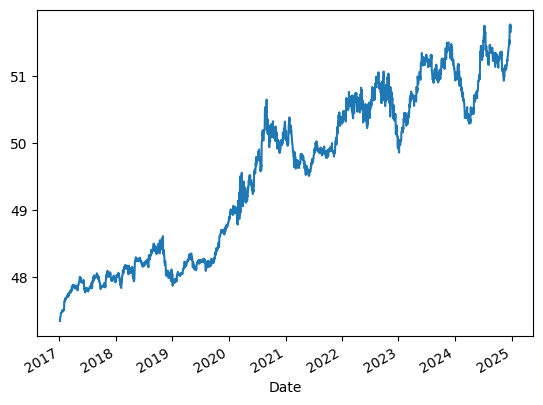

In [18]:
# With this we are plotting the average RSI over the years for "AAPL"
dataset.xs("AAPL", level = 1)["rsi"].plot()

#### Bollinger's Bands

In [19]:
import ta.volatility

def calculate_bollinger_bands(dataset):
    close_log = np.log1p(dataset["close"])
    bb = ta.volatility.BollingerBands(close = close_log, window = 20)
    dataset["bb_low"] = bb.bollinger_lband()
    dataset["bb_mid"] = bb.bollinger_mavg()
    dataset["bb_high"] = bb.bollinger_hband()

    return dataset

dataset = dataset.groupby(level = 1).apply(calculate_bollinger_bands)

In [20]:
dataset

Price                          close        high         low        open  \
Ticker Date       Ticker                                                   
A      2017-01-03 A        43.824730   44.069823   43.117727   43.296833   
       2017-01-04 A        44.399750   44.663700   44.135803   44.239498   
       2017-01-05 A        43.871861   44.371474   43.702180   44.352621   
       2017-01-06 A        45.238724   45.314135   43.890706   43.956692   
       2017-01-09 A        45.380131   45.776054   45.163317   45.257583   
...                              ...         ...         ...         ...   
ZTS    2024-12-20 ZTS     164.839996  166.389999  163.529999  163.759995   
       2024-12-23 ZTS     164.279999  165.830002  162.729996  164.839996   
       2024-12-24 ZTS     164.699997  165.039993  162.740005  163.699997   
       2024-12-26 ZTS     165.520004  165.789993  163.020004  163.720001   
       2024-12-27 ZTS     164.600006  166.529999  163.520004  164.949997   

Price                        volume   adj close  garman_klass_vol        rsi  \
Ticker Date       Ticker                                                       
A      2017-01-03 A       1739600.0   43.824730          0.000182        NaN   
       2017-01-04 A       1821300.0   44.399750          0.000066  48.659753   
       2017-01-05 A       1503700.0   43.871861          0.000070  48.592383   
       2017-01-06 A       2883400.0   45.238724          0.000190  48.712288   
       2017-01-09 A       2575300.0   45.380131          0.000088  48.713432   
...                             ...         ...               ...        ...   
ZTS    2024-12-20 ZTS     6220100.0  164.839996          0.000134  50.000402   
       2024-12-23 ZTS     2437800.0  164.279999          0.000174  49.993465   
       2024-12-24 ZTS     1023600.0  164.699997          0.000084  49.973737   
       2024-12-26 ZTS     2167200.0  165.520004          0.000096  49.980561   
       2024-12-27 ZTS     1800100.0  164.600006          0.000165  49.988875   

Price                       bb_low    bb_mid   bb_high  
Ticker Date       Ticker                                
A      2017-01-03 A            NaN       NaN       NaN  
       2017-01-04 A            NaN       NaN       NaN  
       2017-01-05 A            NaN       NaN       NaN  
       2017-01-06 A            NaN       NaN       NaN  
       2017-01-09 A            NaN       NaN       NaN  
...                            ...       ...       ...  
ZTS    2024-12-20 ZTS     5.117464  5.168648  5.219832  
       2024-12-23 ZTS     5.107714  5.164952  5.222191  
       2024-12-24 ZTS     5.100305  5.160894  5.221483  
       2024-12-26 ZTS     5.094538  5.157927  5.221317  
       2024-12-27 ZTS     5.088546  5.154390  5.220234  

[991254 rows x 11 columns]

#### ATR (Average True Range)

In [21]:
def calculate_atr(dataset):
    atr = ta.volatility.AverageTrueRange(
        high = dataset["high"],
        low = dataset["low"],
        close = dataset["close"],
        window = 20
    ).average_true_range()

    dataset["atr"] = (atr - atr.mean()) / atr.std()

    return dataset

dataset = calculate_atr(dataset)

In [22]:
dataset.tail()

Price                          close        high         low        open  \
Ticker Date       Ticker                                                   
ZTS    2024-12-20 ZTS     164.839996  166.389999  163.529999  163.759995   
       2024-12-23 ZTS     164.279999  165.830002  162.729996  164.839996   
       2024-12-24 ZTS     164.699997  165.039993  162.740005  163.699997   
       2024-12-26 ZTS     165.520004  165.789993  163.020004  163.720001   
       2024-12-27 ZTS     164.600006  166.529999  163.520004  164.949997   

Price                        volume   adj close  garman_klass_vol        rsi  \
Ticker Date       Ticker                                                       
ZTS    2024-12-20 ZTS     6220100.0  164.839996          0.000134  50.000402   
       2024-12-23 ZTS     2437800.0  164.279999          0.000174  49.993465   
       2024-12-24 ZTS     1023600.0  164.699997          0.000084  49.973737   
       2024-12-26 ZTS     2167200.0  165.520004          0.000096  49.980561   
       2024-12-27 ZTS     1800100.0  164.600006          0.000165  49.988875   

Price                       bb_low    bb_mid   bb_high       atr  
Ticker Date       Ticker                                          
ZTS    2024-12-20 ZTS     5.117464  5.168648  5.219832  0.048279  
       2024-12-23 ZTS     5.107714  5.164952  5.222191  0.043046  
       2024-12-24 ZTS     5.100305  5.160894  5.221483  0.032884  
       2024-12-26 ZTS     5.094538  5.157927  5.221317  0.026280  
       2024-12-27 ZTS     5.088546  5.154390  5.220234  0.021564

#### MACD

In [24]:
import ta.trend

def compute_macd(dataset):
    macd = ta.trend.MACD(close = dataset["close"],
                         window_slow = 26,
                         window_fast = 12,
                         window_sign = 9).macd()
    
    macd = (macd - macd.mean())/ macd.std()
    dataset["macd"] = macd
    return dataset

dataset = compute_macd(dataset)

In [25]:
dataset.tail()

Price                          close        high         low        open  \
Ticker Date       Ticker                                                   
ZTS    2024-12-20 ZTS     164.839996  166.389999  163.529999  163.759995   
       2024-12-23 ZTS     164.279999  165.830002  162.729996  164.839996   
       2024-12-24 ZTS     164.699997  165.039993  162.740005  163.699997   
       2024-12-26 ZTS     165.520004  165.789993  163.020004  163.720001   
       2024-12-27 ZTS     164.600006  166.529999  163.520004  164.949997   

Price                        volume   adj close  garman_klass_vol        rsi  \
Ticker Date       Ticker                                                       
ZTS    2024-12-20 ZTS     6220100.0  164.839996          0.000134  50.000402   
       2024-12-23 ZTS     2437800.0  164.279999          0.000174  49.993465   
       2024-12-24 ZTS     1023600.0  164.699997          0.000084  49.973737   
       2024-12-26 ZTS     2167200.0  165.520004          0.000096  49.980561   
       2024-12-27 ZTS     1800100.0  164.600006          0.000165  49.988875   

Price                       bb_low    bb_mid   bb_high       atr      macd  
Ticker Date       Ticker                                                    
ZTS    2024-12-20 ZTS     5.117464  5.168648  5.219832  0.048279 -0.190283  
       2024-12-23 ZTS     5.107714  5.164952  5.222191  0.043046 -0.214765  
       2024-12-24 ZTS     5.100305  5.160894  5.221483  0.032884 -0.229306  
       2024-12-26 ZTS     5.094538  5.157927  5.221317  0.026280 -0.233804  
       2024-12-27 ZTS     5.088546  5.154390  5.220234  0.021564 -0.239468

#### Dollar Volume

In [27]:
dataset["dollar_vol"] = (dataset["adj close"] * dataset["volume"]) / 1e6

In [28]:
dataset.tail()

Price                          close        high         low        open  \
Ticker Date       Ticker                                                   
ZTS    2024-12-20 ZTS     164.839996  166.389999  163.529999  163.759995   
       2024-12-23 ZTS     164.279999  165.830002  162.729996  164.839996   
       2024-12-24 ZTS     164.699997  165.039993  162.740005  163.699997   
       2024-12-26 ZTS     165.520004  165.789993  163.020004  163.720001   
       2024-12-27 ZTS     164.600006  166.529999  163.520004  164.949997   

Price                        volume   adj close  garman_klass_vol        rsi  \
Ticker Date       Ticker                                                       
ZTS    2024-12-20 ZTS     6220100.0  164.839996          0.000134  50.000402   
       2024-12-23 ZTS     2437800.0  164.279999          0.000174  49.993465   
       2024-12-24 ZTS     1023600.0  164.699997          0.000084  49.973737   
       2024-12-26 ZTS     2167200.0  165.520004          0.000096  49.980561   
       2024-12-27 ZTS     1800100.0  164.600006          0.000165  49.988875   

Price                       bb_low    bb_mid   bb_high       atr      macd  \
Ticker Date       Ticker                                                     
ZTS    2024-12-20 ZTS     5.117464  5.168648  5.219832  0.048279 -0.190283   
       2024-12-23 ZTS     5.107714  5.164952  5.222191  0.043046 -0.214765   
       2024-12-24 ZTS     5.100305  5.160894  5.221483  0.032884 -0.229306   
       2024-12-26 ZTS     5.094538  5.157927  5.221317  0.026280 -0.233804   
       2024-12-27 ZTS     5.088546  5.154390  5.220234  0.021564 -0.239468   

Price                      dollar_vol  
Ticker Date       Ticker               
ZTS    2024-12-20 ZTS     1025.321261  
       2024-12-23 ZTS      400.481781  
       2024-12-24 ZTS      168.586917  
       2024-12-26 ZTS      358.714953  
       2024-12-27 ZTS      296.296471